In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Raw Data

In [2]:
import pandas as pd
import numpy as np
from collections import Counter

In [13]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer

In [8]:
train = pd.read_csv('/content/drive/MyDrive/MachineLearning/Data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/MachineLearning/Data/test.csv')

In [10]:
train = train[ train['Churn Category'].notna() ]

In [15]:
train.head(3)

,Customer ID,Age,Number of Dependents,IsMale,IsUnder30,IsSenior,IsMarried,HasDependents,Population,Latitude,Longitude,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,City_Alturas,City_Alviso,City_Amador City,City_Amboy,City_Anaheim,City_Anderson,City_Angels Camp,City_Angelus Oaks,City_Angwin,City_Annapolis,...,City_Zenia,Satisfaction Score,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Contract,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Bin Referred a Friend,Offer_None,Offer_Offer A,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Bin Phone Service,Bin Multiple Lines,Bin Internet Service,Internet Type_Cable,Internet Type_DSL,Internet Type_Fiber Optic,Internet Type_None,Bin Online Security,Bin Online Backup,Bin Device Protection Plan,Bin Premium Tech Support,Bin Streaming TV,Bin Streaming Movies,Bin Streaming Music,Bin Unlimited Data,Bin Paperless Billing,Payment Method_Bank Withdrawal,Payment Method_Credit Card,Payment Method_Mailed Check,Churn Category
0,0650-BWOZN,37.0,0.0,1.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,35.0,NaN,16.0,12.0,85.15,3030.60,0.0,0.0,892.85,3923.45,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,0.0,1.0,NaN,0.0,1.0,1.0,1.0,0.0,0.0,1.0
1,0562-FGDCR,54.0,0.0,NaN,0.0,0.0,0.0,0.0,14931.0,34.903052,-118.411251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.00,29.0,1.0,35.90,35.90,0.0,0.0,0.00,35.90,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,1.0
2,6688-UZPWD,NaN,NaN,1.0,1.0,0.0,NaN,1.0,32304.0,33.721917,-118.043237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,4.0,35.0,41.02,NaN,12.0,20.05,746.75,NaN,0.0,1435.70,2182.45,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0


# Select Feature

## Fixing X (feature) data

In [19]:
choose_conti = ['Satisfaction Score', 'Contract', 'Tenure in Months']
choose_bin = ['Bin Internet Service', 'HasDependents', 'Internet Type_None', 'Internet Type_Fiber Optic', 'Offer_Offer E']

tmp1 = train[ choose_conti ]
tmp2 = train[ choose_bin ]
# X = train[ choose_conti+choose_bin ]

In [33]:
imp = SimpleImputer( missing_values = np.nan, strategy='most_frequent' )
imp = imp.fit(tmp1)

tmp1_imp = imp.transform(tmp1)
normalized_tmp1 = 10*( tmp1_imp-tmp1_imp.mean() )/tmp1_imp.std()

In [44]:
imp = SimpleImputer( missing_values = np.nan, strategy='most_frequent' )
imp = imp.fit(tmp2)

tmp2_imp = imp.transform(tmp2)
# normalized_tmp1 = ( tmp1_imp-tmp1_imp.mean())/tmp1_imp.std()

In [45]:
X = np.concatenate((normalized_tmp1, tmp2_imp), axis=1)

In [46]:
pd.DataFrame(X).head(3)

,0,1,2,3,4,5,6,7
0,-6.035832,0.003898,12.632424,1.0,0.0,0.0,1.0,0.0
1,-6.035832,-6.035832,-6.035832,1.0,0.0,0.0,0.0,1.0
2,-4.937700,0.003898,12.632424,0.0,1.0,1.0,0.0,0.0


Check that all nan values have been filled

In [47]:
pd.DataFrame(X).isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

## y data

In [49]:
y = train['Churn Category'].to_numpy()

Verify shapes

In [51]:
X.shape, y.shape

((4226, 8), (4226,))

# Apply AdaBoost

In [58]:
import numpy as np
import random
import math

In [52]:
def stump(x, y, u):
    '''x: one dimension feature'''
    N, dim = X.shape
    feature_x_sorted = np.sort(x)
    thetas = [ feature_x_sorted[0]-1 ] # left-most
    for n in range(N-2):
        thetas.append( (feature_x_sorted[n]+feature_x_sorted[n+1])/2 )
    thetas.append( feature_x_sorted[-1]+1 ) # right-most

    best_err = 1.01 # initialize with "101% err"
    for theta in thetas:
        y_pred = np.sign(x-theta) # Nx1 array with {-1,1}
        err_pos = np.sum( (y != 1*y_pred)*u ) / N
        err_neg = np.sum( (y != -1*y_pred)*u ) / N
        err = err_neg if err_neg < err_pos else err_pos
        s = -1 if err_neg < err_pos else 1
        
        if err < best_err or (err==best_err and random.random()>0.5):
            best_s = s
            best_theta = theta
            best_err = err
    
    return best_s, best_theta, best_err

In [53]:
def stump_mult(X, y, u):
    N, dim = X.shape
    best_err = 1.01 # initialize as "101% wrong"
    for d in range(dim):
        s_d, theta_d, err_d = stump(X[:,d], y, u)
        if err_d < best_err or (err_d==best_err and random.random()>0.5):
            best_d = d
            best_s = s_d
            best_theta = theta_d
            best_err = err_d

    result = {'d': best_d, 's': best_s, 'theta': best_theta, 'err': best_err}
    return result

In [56]:
def calc_E_Gt(X, y, params, alphas, uniform=False):
    N,dim = X.shape
    T = len(alphas)
    G = np.zeros(N)
    for t in range(T):
        d, s, theta = params[t]['d'], params[t]['s'], params[t]['theta']
        x_d = X[:,d]
        gt = s*np.sign(x_d-theta)
        # G = G + alphas[t]*gt
        if uniform:
            G = G + gt
        elif not uniform:
            G = G + (alphas[t]*gt)

    return np.sum(np.sign(G)!=y) / len(y)

## begin training

In [68]:
pd.DataFrame(y).describe()

,0
count,4226.000000
mean,0.597018
std,1.229299
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,5.000000


In [55]:
ITER = 500

In [ ]:
# ADA Boost
N,dim = X.shape

for label in [0,1,2,3,4,5]:
    us = [np.ones(N)/N]  # u_0 [1/N, 1/N, ... 1/N]
    alphas = []
    params = []

    e_Gs = []
    e_gs = []

    for t in range(ITER):
    # for t in range(ITER):
        print(t)
        param = stump_mult(X, y, us[t])
        params.append( param )

        epsilon_t = param['err']*N / np.sum(us[t])
        diamond_t = math.sqrt( (1-epsilon_t)/epsilon_t )

        s, theta, x_d = param['s'], param['theta'], X[:,param['d']]
        y_pred = s * np.sign( x_d-theta )

        # if correct, u <-- u/diamond_t. Else, u <-- u*diamond_t
        us.append( np.where( y==y_pred, us[-1]/diamond_t, us[-1]*diamond_t ) )
        alphas.append( math.log(diamond_t) )

        # calculate E_in_G
        e_Gs.append( calc_E_Gt(X, y, params, alphas, uniform=False) )
        e_gs.append( np.sum(y!=y_pred)/N )

## use test set

In [60]:
choose_conti = ['Satisfaction Score', 'Contract', 'Tenure in Months']
choose_bin = ['Bin Internet Service', 'HasDependents', 'Internet Type_None', 'Internet Type_Fiber Optic', 'Offer_Offer E']

tmp1 = test[ choose_conti ]
tmp2 = test[ choose_bin ]

imp = SimpleImputer( missing_values = np.nan, strategy='most_frequent' )
imp = imp.fit(tmp1)

tmp1_imp = imp.transform(tmp1)
normalized_tmp1 = 10*( tmp1_imp-tmp1_imp.mean() )/tmp1_imp.std()

imp = SimpleImputer( missing_values = np.nan, strategy='most_frequent' )
imp = imp.fit(tmp2)

tmp2_imp = imp.transform(tmp2)

X_test = np.concatenate((normalized_tmp1, tmp2_imp), axis=1)

In [61]:
X_test.shape

(1409, 8)

In [62]:
for t in range(len(alphas)):
    d, s, theta = params[t]['d'], params[t]['s'], params[t]['theta']
    x_d = X_test[:,d]
    param = params[t]
    y_test_pred = s*np.sign(x_d-theta)
    # e_out_gs.append( np.sum(y2!=y2_pred)/len(y2) )
    # e_out_Gs.append( calc_E_Gt(X2, y2, params[:t], alphas[:t]) )

In [66]:
pd.DataFrame(y_test_pred).describe()

,0
count,1409.000000
mean,0.359830
std,0.480121
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


# Use sklearn

In [76]:
choose_conti = ['Satisfaction Score', 'Contract', 'Tenure in Months']
choose_bin = ['Bin Internet Service', 'HasDependents', 'Internet Type_None', 'Internet Type_Fiber Optic', 'Offer_Offer E']

tmp1 = train[ choose_conti ]
tmp2 = train[ choose_bin ]

imp = SimpleImputer( missing_values = np.nan, strategy='most_frequent' )
imp = imp.fit(tmp1)

tmp1_imp = imp.transform(tmp1)
normalized_tmp1 = 10*( tmp1_imp-tmp1_imp.mean() )/tmp1_imp.std()

imp = SimpleImputer( missing_values = np.nan, strategy='most_frequent' )
imp = imp.fit(tmp2)

tmp2_imp = imp.transform(tmp2)

X_train = np.concatenate((normalized_tmp1, tmp2_imp), axis=1)
y_train = train['Churn Category'].to_numpy()

In [77]:
X_train.shape, y_train.shape

((4226, 8), (4226,))

In [78]:
choose_conti = ['Satisfaction Score', 'Contract', 'Tenure in Months']
choose_bin = ['Bin Internet Service', 'HasDependents', 'Internet Type_None', 'Internet Type_Fiber Optic', 'Offer_Offer E']

tmp1 = test[ choose_conti ]
tmp2 = test[ choose_bin ]

imp = SimpleImputer( missing_values = np.nan, strategy='most_frequent' )
imp = imp.fit(tmp1)

tmp1_imp = imp.transform(tmp1)
normalized_tmp1 = 10*( tmp1_imp-tmp1_imp.mean() )/tmp1_imp.std()

imp = SimpleImputer( missing_values = np.nan, strategy='most_frequent' )
imp = imp.fit(tmp2)

tmp2_imp = imp.transform(tmp2)

X_test = np.concatenate((normalized_tmp1, tmp2_imp), axis=1)

In [73]:
X_test.shape

(1409, 8)

## Validation


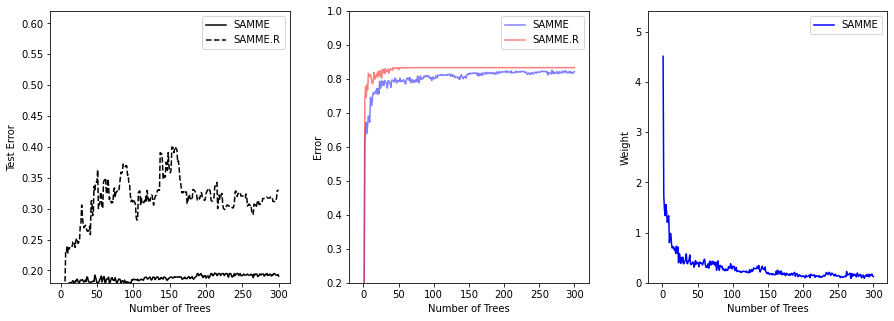

In [75]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


# X, y = make_gaussian_quantiles(
#     n_samples=13000, n_features=10, n_classes=3, random_state=1
# )

n_split = 3000

X_train, X_test = X_train[:n_split], X_train[n_split:]
y_train, y_test = y_train[:n_split], y_train[n_split:]

bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1
)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1.5,
    algorithm="SAMME",
)

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_train_predict in zip(
    bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)
):
    real_test_errors.append(1.0 - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(1.0 - accuracy_score(discrete_train_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1), discrete_test_errors, c="black", label="SAMME")
plt.plot(
    range(1, n_trees_real + 1),
    real_test_errors,
    c="black",
    linestyle="dashed",
    label="SAMME.R",
)
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel("Test Error")
plt.xlabel("Number of Trees")

plt.subplot(132)
plt.plot(
    range(1, n_trees_discrete + 1),
    discrete_estimator_errors,
    "b",
    label="SAMME",
    alpha=0.5,
)
plt.plot(
    range(1, n_trees_real + 1), real_estimator_errors, "r", label="SAMME.R", alpha=0.5
)
plt.legend()
plt.ylabel("Error")
plt.xlabel("Number of Trees")
plt.ylim((0.2, max(real_estimator_errors.max(), discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights, "b", label="SAMME")
plt.legend()
plt.ylabel("Weight")
plt.xlabel("Number of Trees")
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()

## Real Shit


In [106]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1
)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1.5,
    algorithm="SAMME",
)

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

bdt_real.staged_predict(X_test)
bdt_discrete.staged_predict(X_test)

<generator object AdaBoostClassifier.staged_predict at 0x7fb1c232ce50>

In [93]:
from collections import Counter

Counter( bdt_discrete.predict(X_test) )
# pd.DataFrame(bdt_discrete.predict(X_test))

Counter({0.0: 1143, 1.0: 220, 2.0: 11, 3.0: 19, 4.0: 10, 5.0: 6})

In [103]:
y_test_pred = pd.concat( [test['Customer ID'] , pd.DataFrame( data=bdt_discrete.predict(X_test), columns=['Churn Category'] ).astype(int)], axis=1 )

In [104]:
y_test_pred.to_csv('AdaBoost01.csv', index=False)

In [107]:
y_test_pred = pd.concat( [test['Customer ID'] , pd.DataFrame( data=bdt_real.predict(X_test), columns=['Churn Category'] ).astype(int)], axis=1 )

In [110]:
Counter( y_test_pred['Churn Category'] )

Counter({0: 1015, 1: 49, 2: 119, 3: 44, 4: 51, 5: 131})

In [111]:
y_test_pred.to_csv('AdaBoostReal01.csv', index=False)

In [83]:
i = 0
for discrete_train_predict in bdt_discrete.staged_predict(X_test):
    # print( discrete_train_predict )
    i += 1
print(i)

300


In [81]:
for real_test_predict in bdt_real.staged_predict(X_test):
    print(real_test_predict)

[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 2. 0. 0.]
[0. 0. 0. ... 2. 0. 0.]
[0. 0. 0. ... 2. 0. 0.]
[0. 0. 0. ... 2. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[5. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 2. 0. 0.]
[0. 0. 0. ... 2. 0. 0.]
[0. 0. 0. ... 2. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 1.